# 490 GeoSpatial Data Science Final: Whale Migration: Temperature Analysis
### Gage Doyle
#### 05/17/2024


In [1]:
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import netCDF4
import h5netcdf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

In [2]:

# Define the directory containing the files
directory = ".././Data/e4"

# Empty xarray dataset to store merged data
merged_1999 = None
merged_2008 = None

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".nc"):  # Check if the file is a netCDF file
        file_path = os.path.join(directory, filename)
        # Load dataset
        dataset = xr.open_dataset(file_path)
        # Extract the time period from the filename
        time_period = filename.split(".")[2]  # Assuming the filename format is "ersst.v4.yyyymm.nc"
        # Merge subsets sequentially for 1999
        if time_period.startswith("1999"):
            if merged_1999 is None:
                merged_1999 = dataset
            else:
                merged_1999 = xr.merge([merged_1999, dataset])
        # Merge subsets sequentially for 2008
        elif time_period.startswith("2008"):
            if merged_2008 is None:
                merged_2008 = dataset
            else:
                merged_2008 = xr.merge([merged_2008, dataset])


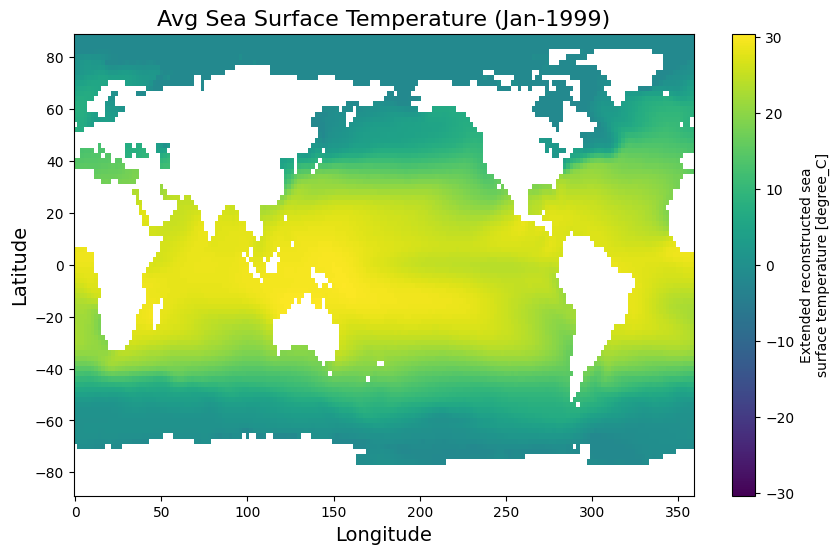

In [3]:
# Plotting merged_1999.sst without clipping and with a preferred style
plt.figure(figsize=(10, 6))
im = merged_1999.sst[0].plot(cmap='viridis')
plt.title('Avg Sea Surface Temperature (Jan-1999)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

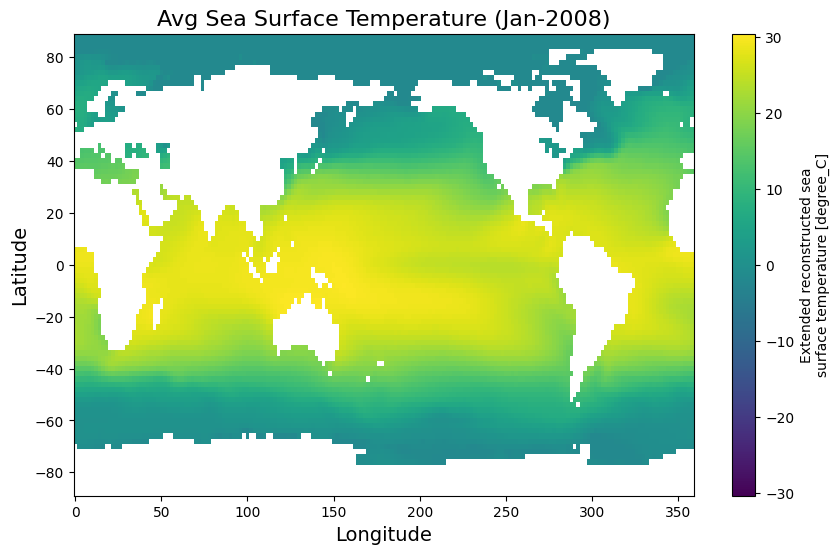

In [4]:
# Plotting merged_1999.sst without clipping and with a preferred style
plt.figure(figsize=(10, 6))
im = merged_1999.sst[0].plot(cmap='viridis')
plt.title('Avg Sea Surface Temperature (Jan-2008)', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

In [5]:
# avg temp for each lat lon for all of '08
avg_sst_1999 = merged_1999.groupby("time.year").mean()

In [6]:
# avg temp for each lat lon for all of '99
avg_sst_2008 = merged_2008.groupby("time.year").mean()

In [7]:
# Reproject to Cal-Coast utm from epsg.io
avg_sst_2008_proj = avg_sst_2008.rio.write_crs("EPSG:3310")

In [8]:
# Reproject to Cal-Coast u from epsg.io
avg_sst_1999_proj = avg_sst_1999.rio.write_crs("EPSG:3310")

In [9]:
#clipped extent
avg_sst_1999_proj = avg_sst_1999_proj.rio.clip_box(minx= 194.338, miny=4.606, maxx=305.638, maxy=53.148)
avg_sst_2008_proj = avg_sst_2008_proj.rio.clip_box(minx= 194.338, miny=4.606, maxx=305.638, maxy=53.148)

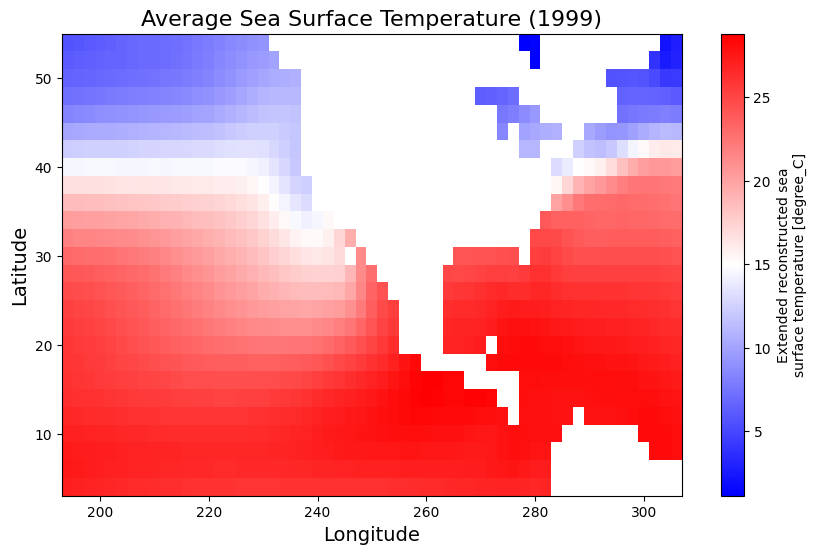

In [10]:
# Plotting avg_sst_1999_proj.sst
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting avg_sst_2008_proj.sst without automatically generating color bar
im = avg_sst_1999_proj.sst.plot(ax=ax, cmap='bwr')

# Set title and axis labels
ax.set_title('Average Sea Surface Temperature (1999)', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('avg_sst_1999.png', bbox_inches='tight')
plt.show()

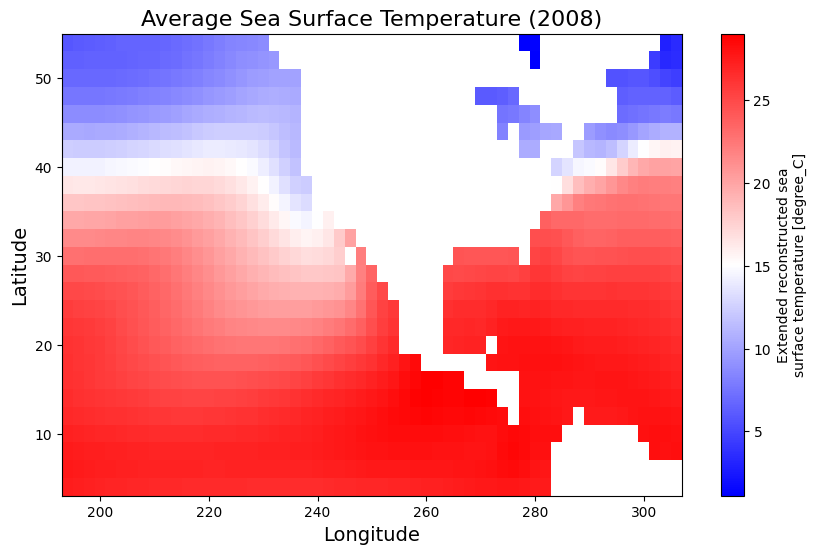

In [40]:
# Plotting avg_sst_2008_proj.sst
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#2c7bb6', '#abd9e9', '#f0f0f0', '#fdae61', '#d7191c'])

# Plotting avg_sst_2008_proj.sst without automatically generating color bar
im = avg_sst_2008_proj.sst.plot(ax=ax, cmap='bwr')

# Set title and axis labels
ax.set_title('Average Sea Surface Temperature (2008)', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('avg_sst_2008.png', bbox_inches='tight')
plt.show()

In [12]:
# Convert to DataFrame with only lat, lon, and sst
df_sst_2008 = avg_sst_2008_proj.sst.to_dataframe().reset_index()[['lat', 'lon', 'sst']]
df_sst_1999 = avg_sst_1999_proj.sst.to_dataframe().reset_index()[['lat', 'lon', 'sst']]


In [13]:
# Identify avg temp of 08
df_sst_2008['sst'].mean()
# Identify avg temp of 99
df_sst_1999['sst'].mean()

21.235027

In [14]:
# merge dataframes for change calculations
df_perc_change = pd.merge(df_sst_1999, df_sst_2008, on=['lat','lon'])
df_perc_change = df_perc_change.rename(columns={'sst_x': 'sst_99', 'sst_y': 'sst_08'})

In [15]:
# Change calculations
df_perc_change['change'] = (df_perc_change['sst_08'] - df_perc_change['sst_99'])
df_perc_change['change_percent'] = (((df_perc_change['sst_08'] - df_perc_change['sst_99']) / df_perc_change['sst_99']) * 100)
df_perc_change_mean = df_perc_change['change_percent'].mean()

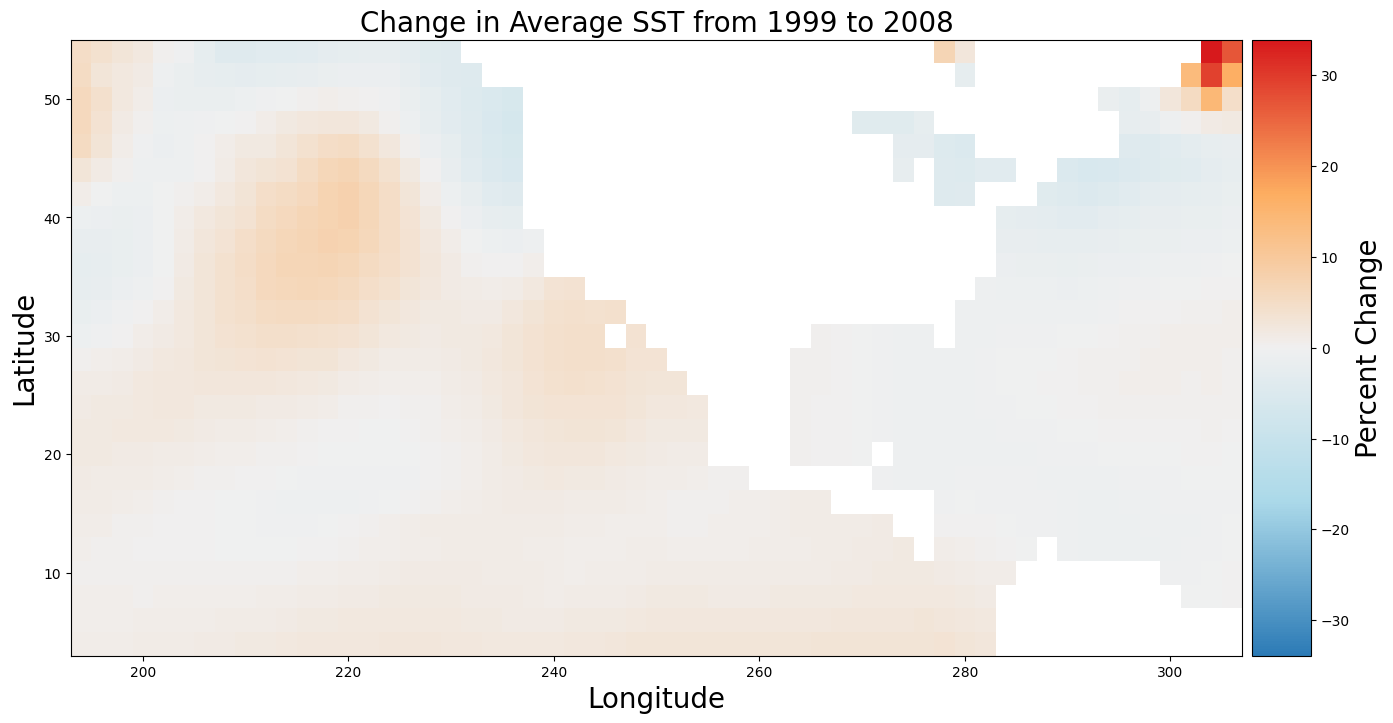

In [35]:
# Convert DataFrame back to an xarray Dataset for plotting
ds_change = df_perc_change.set_index(['lat', 'lon']).to_xarray()

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#2c7bb6', '#abd9e9', '#f0f0f0', '#fdae61', '#d7191c'])

# Plot the SST change
fig, ax = plt.subplots(figsize=(16, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plotting the change in SST
vmin = -6.3718505
vmax = 33.911922
midpoint = 0

# Specify the colormap centered at 0
im = ds_change.change_percent.plot(ax=ax, cbar_ax=cax, cmap=custom_cmap, center=midpoint)
ax.set_title("Change in Average SST from 1999 to 2008", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)
ax.set_xlabel("Longitude", fontsize=20)

# Set colorbar label
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Percent Change", fontsize=20)

plt.savefig('change_sst_1999_2008.png', bbox_inches='tight')
plt.show()

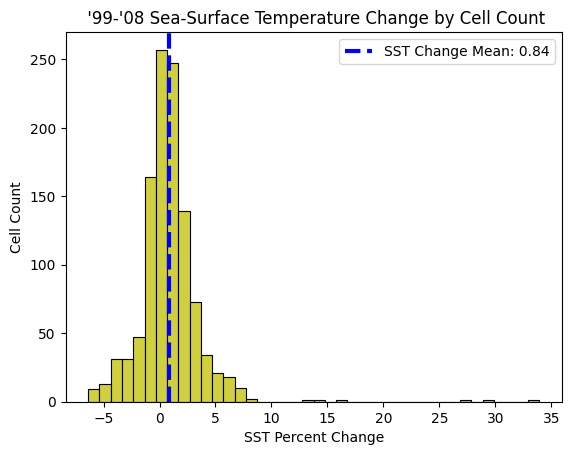

In [19]:
sns.histplot(df_perc_change['change_percent'],binwidth = 1,color = 'y')
plt.title(" '99-'08 Sea-Surface Temperature Change by Cell Count" )
plt.xlabel("SST Percent Change")
plt.ylabel("Cell Count")
plt.axvline(df_perc_change_mean, color = "b", linestyle = '--', lw = 3.0, label = f"SST Change Mean: {df_perc_change_mean:.2f}")
plt.savefig('99-08_Percent_Change_hist.png', bbox_inches='tight')
plt.legend()

In [20]:
#exporting clipped & projected  files:
export_1999 = avg_sst_1999_proj.to_netcdf("export_1999.nc")
export_2008 = avg_sst_2008_proj.to_netcdf("export_2008.nc")
export_change = ds_change.to_netcdf("export_change.nc")